In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import polars as pl

In [3]:
import os
os.getcwd()

'/Users/ryant/Documents/Github/kaggle-challenges/optiver-realizedvolatilityprediction-2022'

In [4]:
import plotly.express as px

# Goal

In this competition, you will be given 10 minutes of book data and we ask you to predict what the volatility will be in the following 10 minutes. 

## FAQ

- What does time_id mean and how the target-feature data are structured?
  - One time_id represents a unique 20-minutes trading window which is consistent across all stocks As an example, let’s say time_id = 1 is representing a window between 1900-01-01 12:00:00 and 1900-01-01 12:20:00, then the book data of all stocks for that time_id are is taken from the same window. The data in the first 10 minutes window is shared with all of you, while the order book data of the second 10-minutes is used to build the target for you to predict. The dataset is rolling in such a way that feature and target data will always have zero overlap.
  - Note that **time_id is randomly shuffled**, so it will not contain any information other than serving as a bridge between different dataset. We do make sure the data point in public test dataset is in the future from training data’s perspective, though.
    - Cannot Concatenate
- Q: Why we have missing “seconds_in_bucket” field?
  - That means there is no related market activities during the last second.
  - For book data you can also assume the top-2 level book shape stays the same as the last available book update within the gap seconds, or, in another word, you can forward fill the missing data point for all field in book data.
  - For trade data, it implies no trade happening within that one-second window. One thing to note that trade data tends to be more sparse than book data in many cases.
- I see in some time_id we miss the order book data for some stocks, what is the reason for that?
  - A: That is because there is no book update in continuous trading session on that period. One potential cause for this is volatility interruption. Actually one European exchange, Deutsche Borse, provides an explanation on this topic as well. Noted that this particular challenge of missing data is also a real-life challenge we are facing in Optiver.
- Intepretation
  - Book-data is basically the snapshot at end of the n(th) second of that time interval.
  - And trade data for nth-second is the amount of trade on that stock that has happened from the ending of (n-1) seconds to ending of n(th) second. The price in trade is then the average price at which the trade happened ?

## Key Definitions

- Order Book - Intention
- Trade - Activity in the market

**Spread**
$$\text{BidAskSpread} = \frac{\text{BestOffer}}{\text{BestBid}} - 1$$

**WAP**
$$\text{WAP} = \frac{\text{BidPrice}_1 * \text{AskSize}_1 + \text{AskPrice}_1 * \text{BidSize}_1}{\text{BidSize}_1 + \text{AskSize}_1}$$

**log returns** - preferred with mathematical modelling

$$r_{t_1, t_2} = \log({\frac{S_{t_2}}{S_{t_1}}})$$

**realized volatility**, $\sigma$, as the squared root of the sum of squared log returns.

$$\sigma = \sqrt{\sum_t r_{t-1, t}^2}$$

The data in the first 10 minutes window is shared with all of you, while the order book data of the second 10-minutes is used to build the target for you to predict. 

## Evaluation Metric

$$\text{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} ((y_i - \hat{y}_i) / y_i)^2}$$

**train.csv** The ground truth values for the training set.

- `stock_id` - Same as above, but since this is a csv the column will load as an integer instead of categorical.
- `time_id` - Same as above.
- `target` - The realized volatility computed over the 10 minute window following the feature data under the same stock/time_id. There is no overlap between feature and target data. You can find more info in our tutorial notebook.

In [5]:
train = pd.read_csv('data/train.csv')
train.head(5)

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


**book_[train/test].parquet** A parquet file partitioned by stock_id. Provides order book data on the most competitive buy and sell orders entered into the market. The top two levels of the book are shared. The first level of the book will be more competitive in price terms, it will then receive execution priority over the second level.

- `stock_id` - ID code for the stock. Not all stock IDs exist in every time bucket. Parquet coerces this column to the categorical data type when loaded; you may wish to convert it to int8.
- `time_id` - ID code for the time bucket. Time IDs are not necessarily sequential but are consistent across all stocks.
- `seconds_in_bucket` - Number of seconds from the start of the bucket, always starting from 0.  (e.g., from 0 to 599 for a 10-minute bucket if sampled every second).
- `bid_price[1/2]` - Normalized prices of the most/second most competitive buy level.
- `ask_price[1/2]` - Normalized prices of the most/second most competitive sell level.
- `bid_size[1/2]` - The number of shares on the most/second most competitive buy level.
- `ask_size[1/2]` - The number of shares on the most/second most competitive sell level.

In [37]:
# Book
stock_id = 0
time_id = 5

book = pd.read_parquet(f'data/book_train.parquet/stock_id={stock_id}')
book.loc[:,'stock_id'] = 0
book['stock_id'] = book['stock_id'].astype('int8')

book['spread'] = (book['ask_price1'] / book['bid_price1']) - 1
book['wap'] = (book['ask_price1'] * book['ask_size1'] + book['bid_price1'] * book['bid_size1']) / (book['ask_size1'] + book['bid_size1'])

book_ex = book[book['time_id'] == time_id]
pd.concat([book_ex.head(5), book_ex.tail(5)])

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,spread,wap
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0,0.000878,1.002290
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0,0.000878,1.002276
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,0.000878,1.002276
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,0.000878,1.002281
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,0.000878,1.002281
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0,0.000619,1.003147
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0,0.000619,1.003147
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0,0.000619,1.003147
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0,0.000619,1.003147
301,5,593,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0,0.000619,1.003147


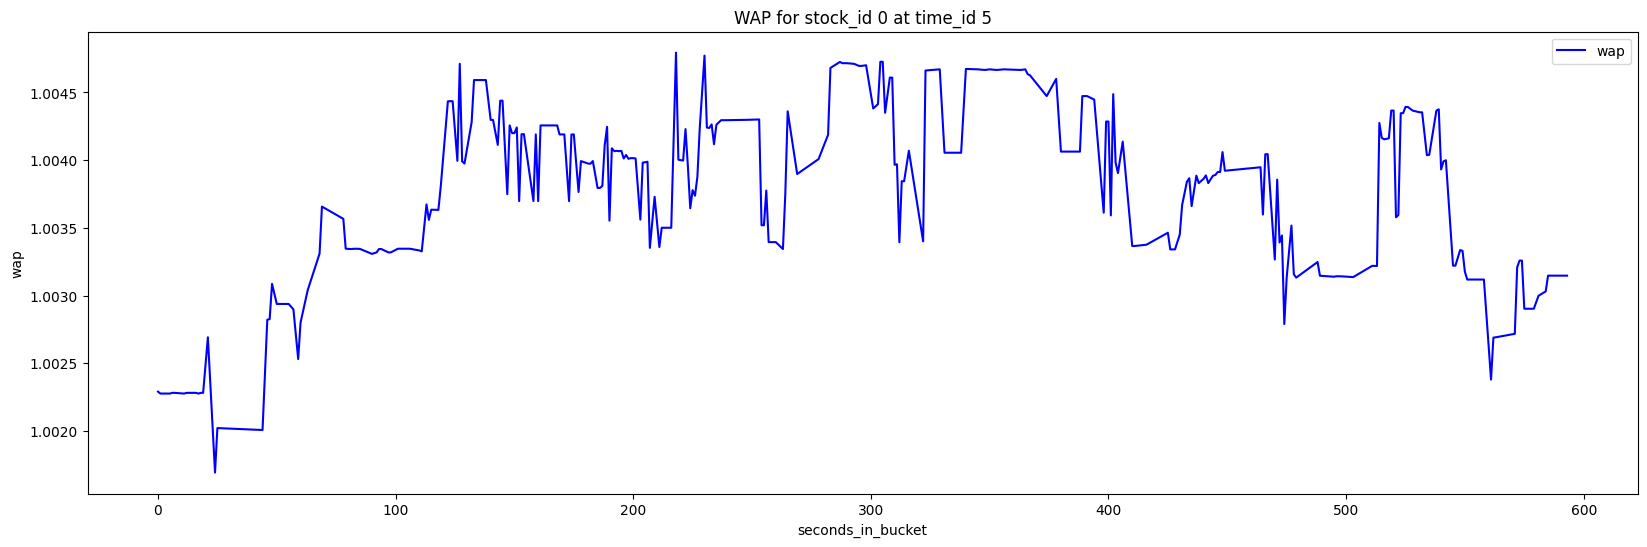

In [41]:
fig, ax1 = plt.subplots(figsize=(20, 6))

sns.lineplot(data=book_ex[book_ex['seconds_in_bucket'] <= 1000], x='seconds_in_bucket', y='wap', ax=ax1, color='blue', errorbar=None, label='wap')

plt.title(f'WAP for stock_id {stock_id} at time_id {time_id}')
plt.show()

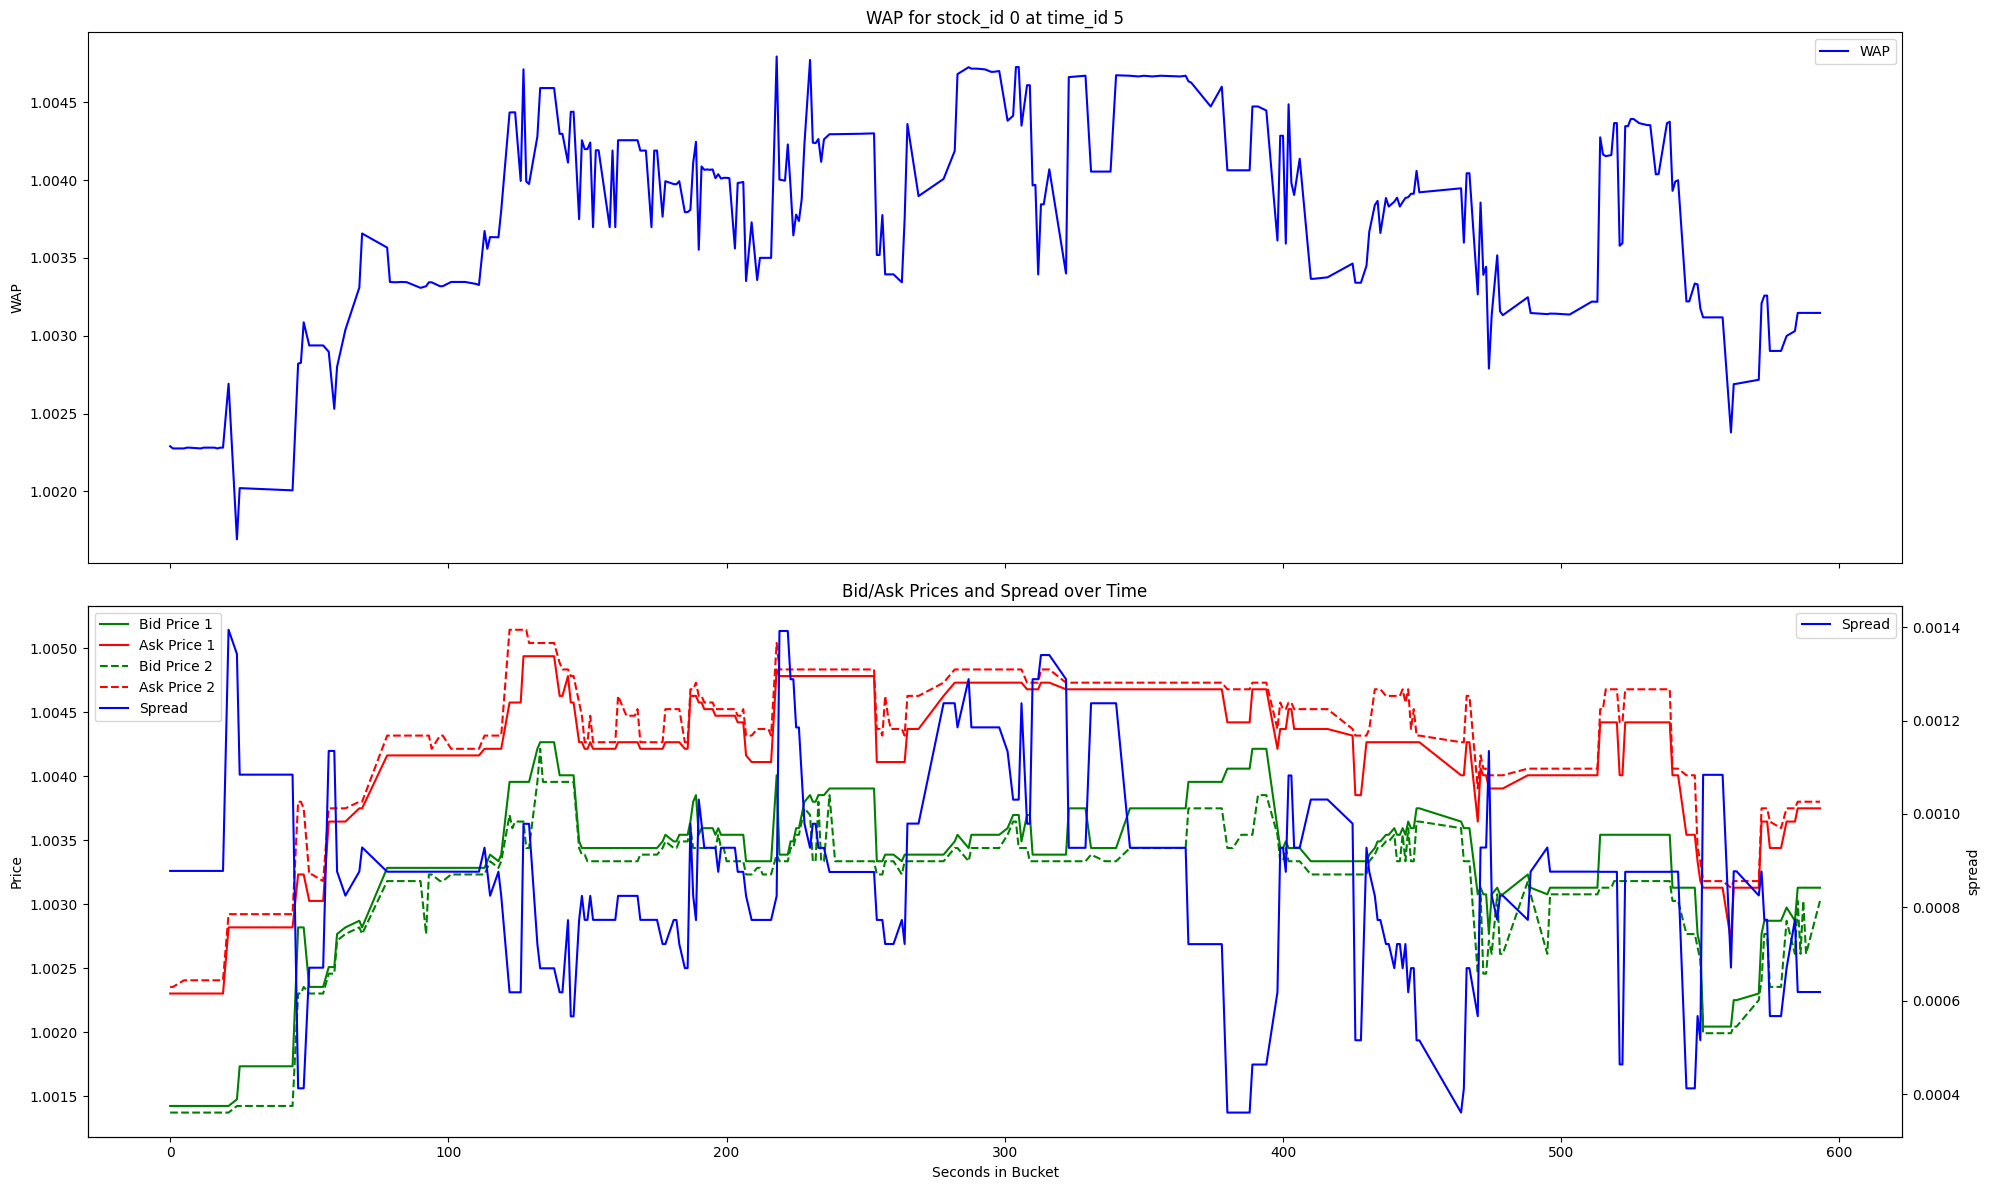

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 12), sharex=True)

# --- First subplot: WAP ---
sns.lineplot(
    data=book_ex[book_ex['seconds_in_bucket'] <= 1000],
    x='seconds_in_bucket',
    y='wap',
    ax=ax1,
    color='blue',
    errorbar=None,
    label='WAP'
)
ax1.set_title(f'WAP for stock_id {stock_id} at time_id {time_id}')
ax1.set_ylabel('WAP')
ax1.legend()

# --- Second subplot: Bid/Ask Prices and Spread ---
# Price lines on primary axis
sns.lineplot(data=book_ex, x='seconds_in_bucket', y='bid_price1', ax=ax2, label='Bid Price 1', color='green', errorbar=None)
sns.lineplot(data=book_ex, x='seconds_in_bucket', y='ask_price1', ax=ax2, label='Ask Price 1', color='red', errorbar=None)
sns.lineplot(data=book_ex, x='seconds_in_bucket', y='bid_price2', ax=ax2, label='Bid Price 2', linestyle='--', color='green', errorbar=None)
sns.lineplot(data=book_ex, x='seconds_in_bucket', y='ask_price2', ax=ax2, label='Ask Price 2', linestyle='--', color='red', errorbar=None)

# Create secondary axis for spread
ax3 = ax2.twinx()
sns.lineplot(data=book_ex, x='seconds_in_bucket', y='spread', ax=ax3, label='Spread', color='blue', errorbar=None)

# Axis labels
ax2.set_ylabel('Price')
ax2.set_xlabel('Seconds in Bucket')
ax2.set_title('Bid/Ask Prices and Spread over Time')

# Combine legends
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines2 + lines3, labels2 + labels3, loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
def log_returns(x):
    return np.log(x).diff()

def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

book_ex.loc[:,'log_return'] = log_returns(book_ex['wap'])
book_ex.head(5)


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,spread,wap,log_return
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,0.000878,1.002290,NaN
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,0.000878,1.002276,-0.000014
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,0.000878,1.002276,0.000000
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,0.000878,1.002281,0.000005
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,0.000878,1.002281,0.000000


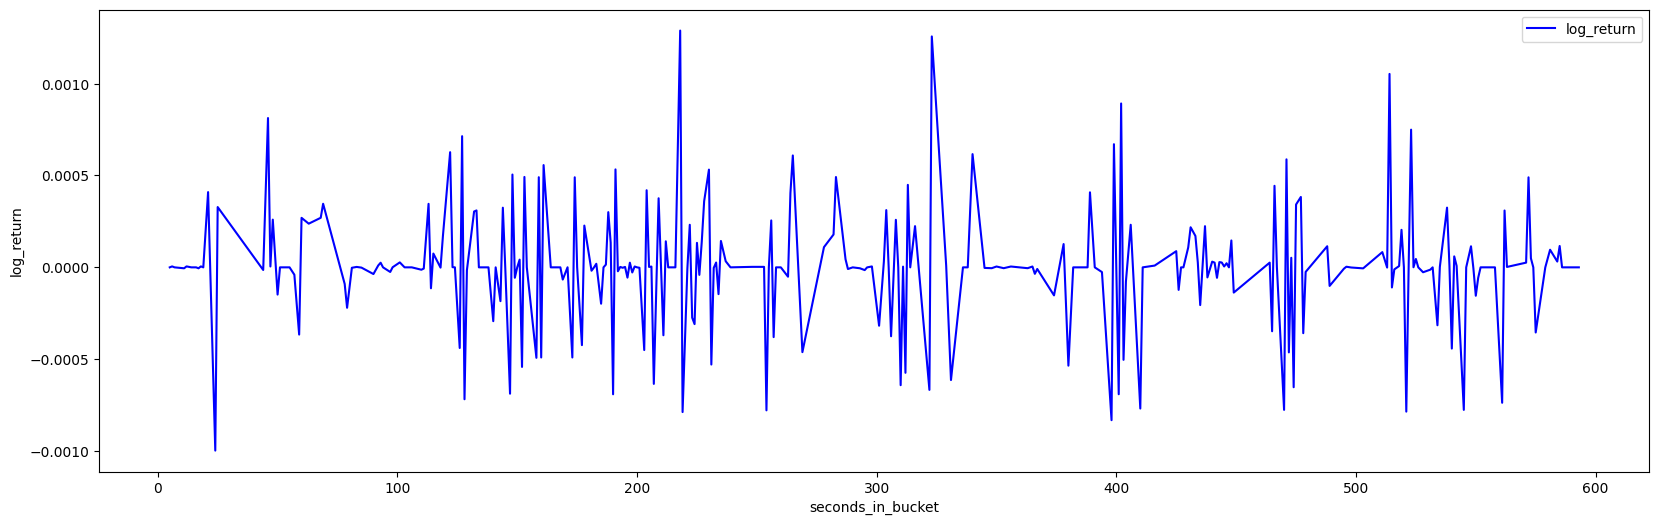

In [24]:
fig, ax1 = plt.subplots(figsize=(20, 6))

sns.lineplot(data=book_ex[book_ex['seconds_in_bucket'] <= 1000], x='seconds_in_bucket', y='log_return', ax=ax1, color='blue', errorbar=None, label='log_return')

plt.show()

**trade_[train/test].parquet** A parquet file partitioned by stock_id. Contains data on trades that actually executed. Usually, in the market, there are more passive buy/sell intention updates (book updates) than actual trades, therefore one may expect this file to be more sparse than the order book.

- `stock_id` - Same as above.
- `time_id` - Same as above.
- `seconds_in_bucket` - Same as above. Note that since trade and book data are taken from the same time window and trade data is more sparse in general, this field is not necessarily starting from 0.
- `price` - The average price of executed transactions happening in one second. Prices have been normalized and the average has been weighted by the number of shares traded in each transaction.
- `size` - The sum number of shares traded.
- `order_count` - The number of unique trade orders taking place.

In [50]:
trade = pd.read_parquet(f'data/trade_train.parquet/stock_id={stock_id}')
trade.loc[:,'stock_id'] = 0
trade['stock_id'] = trade['stock_id'].astype('int8')
trade['average_size'] = trade['size'] / trade['order_count']
trade_ex = trade[trade['time_id'] == time_id]
pd.concat([trade_ex.head(5), trade_ex.tail(5)])

,time_id,seconds_in_bucket,price,size,order_count,stock_id,average_size
0,5,21,1.002301,326,12,0,27.166667
1,5,46,1.002778,128,4,0,32.000000
2,5,50,1.002818,55,1,0,55.000000
3,5,57,1.003155,121,5,0,24.200000
4,5,68,1.003646,4,1,0,4.000000
35,5,551,1.002561,154,5,0,30.800000
36,5,562,1.002715,1,1,0,1.000000
37,5,572,1.003191,499,6,0,83.166667
38,5,581,1.003478,8,3,0,2.666667
39,5,585,1.003646,26,2,0,13.000000


# Naive - Realized Volatility

In [ ]:
from joblib import Parallel, delayed # parallel computing to save time



In [45]:
realized_vol = realized_volatility(book_ex['log_return'])
print(f'Realized volatility for stock_id 0 on time_id 5 is {realized_vol}')

Realized volatility for stock_id 0 on time_id 5 is 0.005466405297934356


In [51]:
import os

os.getcwd()

'/Users/ryant/Documents/Github/kaggle-challenges/optiver-realizedvolatilityprediction-2022'

In [ ]:
from sklearn.metrics import r2_score

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

# R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
# RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
# print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

# Key Questions
- How is volatility measured?
- How does the orderbook determine volatility?
- How does trades affect volatility?
- What is the autocorrelation between the different stocks? does that help in the prediction?
  